# COURSE: A deep understanding of deep learning
## SECTION: FFNs
### LECTURE: FFN to classify digits
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [42]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [43]:
# import dataset (comes with colab!) 
data = np.loadtxt(open('C:/Users/Zlswo/VsCode Projects/DeepUnderstandingOfDeepLearning/sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

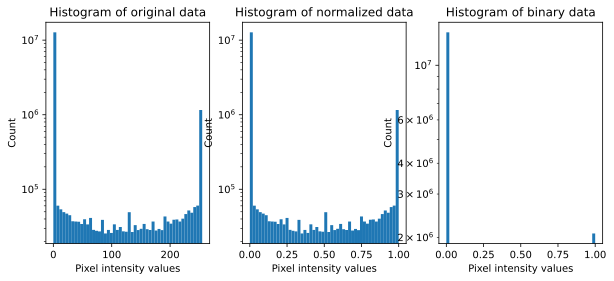

In [44]:
# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)
dataB = preprocessing.Binarizer(threshold=.5).transform(dataNorm)

fig,ax = plt.subplots(1,3,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[0].set_yscale('log')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
ax[1].set_yscale('log')

ax[2].hist(dataB.flatten(),50)
ax[2].set_xlabel('Pixel intensity values')
ax[2].set_ylabel('Count')
ax[2].set_title('Histogram of binary data')
ax[2].set_yscale('log')

plt.show()

# Create train/test groups using DataLoader

In [45]:
# Step 1: convert to tensor
dataT   = torch.tensor( data ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

print(dataT.dtype)

# train_data = train_data / torch.max(train_data)
test_data = test_data / torch.max(test_data)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

torch.float32


In [46]:
print('Training data range %g to %g'
      %(torch.min(train_data.tensors[0]), torch.max(train_data.tensors[0])))
print('Training data range %g to %g'
      %(torch.min(test_data.tensors[0]), torch.max(test_data.tensors[0])))

Training data range 0 to 255
Training data range 0 to 1


In [47]:
# check all variables in workspace
%whos

Variable                 Type             Data/Info
---------------------------------------------------
DataLoader               type             <class 'torch.utils.data.dataloader.DataLoader'>
F                        module           <module 'torch.nn.functio<...>orch\\nn\\functional.py'>
TensorDataset            type             <class 'torch.utils.data.dataset.TensorDataset'>
X                        Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
ax                       ndarray          3: 3 elems, type `object`, 24 bytes
batchsize                int              32
createTheMNISTNet        function         <function createTheMNISTN<...>et at 0x00000213C2FF2D40>
data                     ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataB                    ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataNorm                 ndarray          20000x784: 156800

# Create the DL model

In [48]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [49]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet()

X,y = next(iter(train_loader))
yHat = net(X)

# values are log-probability of each number (0-9)
# print(torch.exp(yHat))

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(5.6618, grad_fn=<NllLossBackward0>)


# Create a function that trains the model

In [50]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 60
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Run the model and show the results!

In [51]:
trainAcc,testAcc,losses,net = function2trainTheModel()


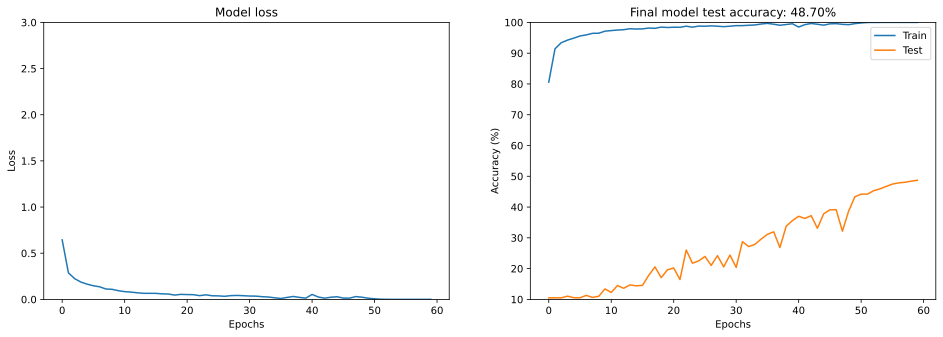

In [52]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Inspect the results in more detail

In [53]:
# run the model through for the test data
X,y = next(iter(test_loader))
predictions = net(X).detach()

predictions

tensor([[-2.1551, -2.5228, -2.1509,  ..., -2.2607, -2.2959, -2.2594],
        [-2.1081, -2.5387, -2.1673,  ..., -2.3968, -2.2410, -2.3247],
        [-2.1537, -2.5674, -2.1820,  ..., -2.3621, -2.2465, -2.3728],
        ...,
        [-2.1794, -2.5295, -2.1059,  ..., -2.4536, -2.0423, -2.2544],
        [-2.1968, -2.4871, -2.2241,  ..., -2.3677, -2.2318, -2.1278],
        [-2.1842, -2.5479, -1.9511,  ..., -2.3347, -2.2328, -2.3998]])

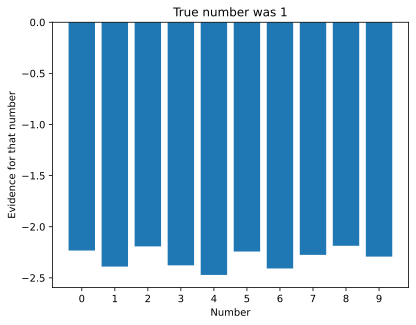

In [54]:
# Evidence for all numbers from one sample
sample2show = 120

plt.bar(range(10),predictions[sample2show]) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' %y[sample2show].item())
plt.show()

[   0    1    2 ... 1989 1992 1993]


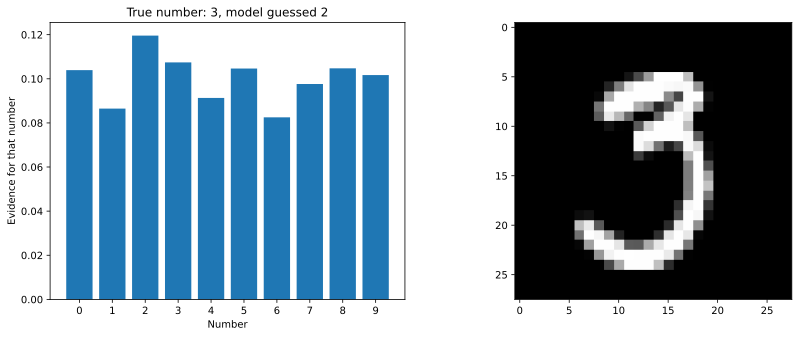

In [55]:
# find the errors
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 10

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s' 
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()

# Additional explorations

In [56]:
# 1) Average together the correct 7's and the error 7's, and make images of them (that is, one image
#    of all correct 7's and one image of all incorrectly labeled 7's). How do they look?
# 
# 2) Repeat #1 for all numbers to produce a 2x10 matrix of images with corrects on top
#    and errors on the bottom.
# 
# 3) Identify "almost errors," which we can define as correct categorizations that had a probability of
#    e.g., >.1 for any other number. Make images of some of these numbers. Can you understand why the model
#    was confused?
# 
# 4) I didn't use .train(), .eval(), or no_grad() here. Is that a problem? Can you add those in without checking
#    other notebooks?
# 